In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import differential_evolution

In [5]:
# Paramètres généraux
R = 0.4          # taux de récupération
N = 120          # nombre de noms
T = 5.0          # maturité (années)
r = 0.0014        # taux sans risque
M = 30000        # Monte Carlo

# Dates de paiement (annuelles)
payment_times = np.arange(1, int(T) + 1)

# Tranches (attachment, detachment)
tranches = [
    (0.00, 0.03),
    (0.03, 0.07),
    (0.07, 0.15),
    (0.15, 1.00)
]


In [6]:
data = {
    "Date": [
        "2014-06-01", "2014-07-03", "2014-08-15", "2014-09-23",
        "2014-10-11", "2014-11-17", "2014-12-01",
        "2015-01-07", "2015-02-10", "2015-03-15"
    ],
    "Tranche_0_3": [4.250, 3.750, 4.094, 3.750, 5.775, 4.188, 3.183, 7.065, 7.559, 6.874],
    "Tranche_3_7": [2.000, 1.375, 1.719, 1.375, 1.810, 0.985, 0.747, 0.875, 0.563, 0.073],
    "Tranche_7_15": [0.036, 0.048, 0.050, 0.056, 0.050, 0.057, 0.060, 0.055, 0.055, 0.064],
    "Tranche_15_100": [0.014, 0.015, 0.014, 0.012, 0.012, 0.015, 0.016, 0.013, 0.014, 0.015],
    "CDS_Index": [39, 37, 38, 37, 41, 35, 32, 39, 37, 34]
}

df = pd.DataFrame(data)
df["Date"] = pd.to_datetime(df["Date"])

# Spreads de marché (en décimal)
market_spreads = df[
    ["Tranche_0_3", "Tranche_3_7", "Tranche_7_15", "Tranche_15_100"]
].values * 1e-2


In [7]:
def discount(t):
    return np.exp(-r * t)

def hazard_from_index(spread_bps):
    # Approximation standard
    return (spread_bps * 1e-4) / (1.0 - R)

def tranche_loss(L, a, d):
    return np.minimum(np.maximum(L - a, 0.0), d - a)


In [8]:
# Common Random Numbers (stabilité de l’optimisation)
rng = np.random.default_rng(42)
Z_fixed = rng.standard_normal((M, N))

def gaussian_copula_uniforms(rho):
    corr = rho * np.ones((N, N)) + (1.0 - rho) * np.eye(N)
    L = np.linalg.cholesky(corr)
    X = Z_fixed @ L.T
    return norm.cdf(X)


In [9]:
def price_tranches(rho, hazard):
    U = gaussian_copula_uniforms(rho)
    tau = -np.log(U) / hazard

    tranche_spreads = []

    for a, d in tranches:
        L_prev = np.zeros(M)
        default_leg = 0.0
        premium_leg = 0.0

        for t in payment_times:
            defaults = (tau <= t).sum(axis=1)
            L = (1 - R) * defaults / N
            Lt = tranche_loss(L, a, d)

            default_leg += discount(t) * np.mean(Lt - L_prev)

            outstanding_prev = d - a - L_prev
            outstanding_now = d - a - Lt
            premium_leg += discount(t) * np.mean(
                0.5 * (outstanding_prev + outstanding_now)
            )

            L_prev = Lt

        spread = default_leg / premium_leg if premium_leg > 0 else 0.0
        tranche_spreads.append(spread)

    return np.array(tranche_spreads)


In [10]:
rho_t = []
model_spreads_all_dates = []

for i in range(len(df)):

    h = hazard_from_index(df.loc[i, "CDS_Index"])
    market = market_spreads[i]

    def objective_relative(x):
        rho = x[0]
        model = price_tranches(rho, h)

        eps = 1e-4  # régularisation pour spreads très faibles
        rel_errors = (model - market) / (market + eps)

        return np.sqrt(np.mean(rel_errors**2))


    res = differential_evolution(
        objective_relative,
        bounds=[(0.01, 0.99)],
        strategy="best1bin",
        maxiter=25,
        popsize=15,
        seed=123,
        polish=True
    )

    rho_star = res.x[0]
    rho_t.append(rho_star)
    model_spreads_all_dates.append(price_tranches(rho_star, h))

    print(f"Date: {df.loc[i, 'Date'].date()}, CDS Index: {df.loc[i, 'CDS_Index']}, "
          f"Optimal rho: {rho_star:.4f}, Market Spreads: {market}, Model Spreads: {model_spreads_all_dates[-1]}")

rho_t = np.array(rho_t)
model_spreads_all_dates = np.array(model_spreads_all_dates)


Date: 2014-06-01, CDS Index: 39, Optimal rho: 0.0957, Market Spreads: [0.0425  0.02    0.00036 0.00014], Model Spreads: [1.49436681e-01 1.57311376e-02 6.32915032e-04 1.25248843e-06]
Date: 2014-07-03, CDS Index: 37, Optimal rho: 0.1136, Market Spreads: [0.0375  0.01375 0.00048 0.00015], Model Spreads: [1.36952480e-01 1.53790389e-02 8.12121634e-04 1.95766046e-06]
Date: 2014-08-15, CDS Index: 38, Optimal rho: 0.1089, Market Spreads: [0.04094 0.01719 0.0005  0.00014], Model Spreads: [1.41983639e-01 1.59081851e-02 8.05014750e-04 1.76196517e-06]
Date: 2014-09-23, CDS Index: 37, Optimal rho: 0.1193, Market Spreads: [0.0375  0.01375 0.00056 0.00012], Model Spreads: [1.35590127e-01 1.57929748e-02 9.18417150e-04 2.03636677e-06]
Date: 2014-10-11, CDS Index: 41, Optimal rho: 0.0921, Market Spreads: [0.05775 0.0181  0.0005  0.00012], Model Spreads: [1.58574851e-01 1.72653402e-02 6.95780327e-04 1.33070051e-06]
Date: 2014-11-17, CDS Index: 35, Optimal rho: 0.1184, Market Spreads: [0.04188 0.00985 0.0

In [11]:
print("Corrélations calibrées par date :")
for d, rho in zip(df["Date"], rho_t):
    print(d.date(), "rho =", round(rho, 3))


Corrélations calibrées par date :
2014-06-01 rho = 0.096
2014-07-03 rho = 0.114
2014-08-15 rho = 0.109
2014-09-23 rho = 0.119
2014-10-11 rho = 0.092
2014-11-17 rho = 0.118
2014-12-01 rho = 0.146
2015-01-07 rho = 0.087
2015-02-10 rho = 0.036
2015-03-15 rho = 0.01


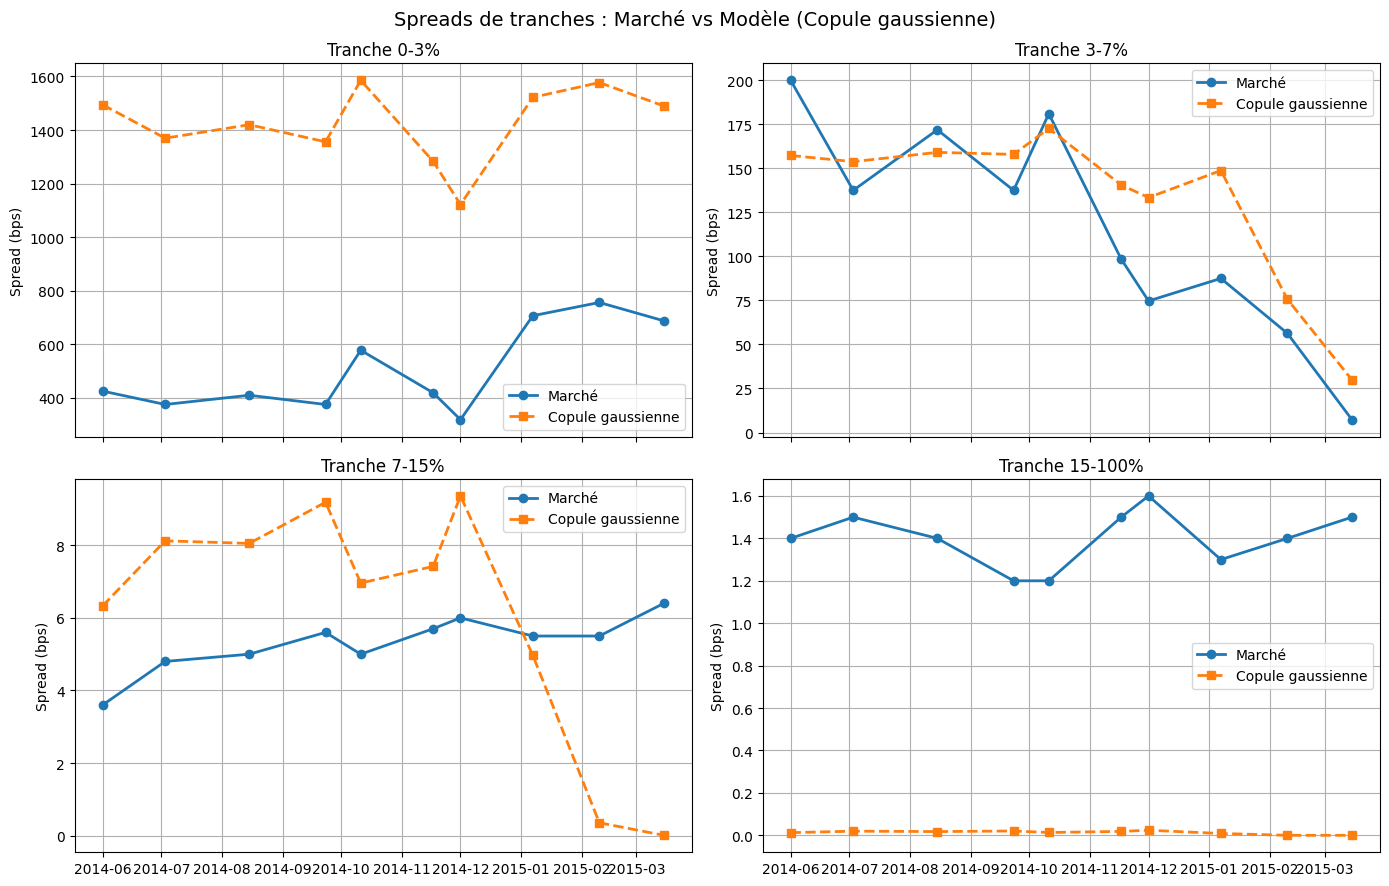

In [12]:
labels = ["0-3%", "3-7%", "7-15%", "15-100%"]
dates = df["Date"]

fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True)
axes = axes.flatten()

for k in range(4):
    ax = axes[k]

    ax.plot(
        dates,
        market_spreads[:, k] * 1e4,
        marker="o",
        label="Marché",
        linewidth=2
    )

    ax.plot(
        dates,
        model_spreads_all_dates[:, k] * 1e4,
        marker="s",
        linestyle="--",
        label="Copule gaussienne",
        linewidth=2
    )

    ax.set_title(f"Tranche {labels[k]}")
    ax.set_ylabel("Spread (bps)")
    ax.grid(True)
    ax.legend()

plt.suptitle("Spreads de tranches : Marché vs Modèle (Copule gaussienne)", fontsize=14)
plt.tight_layout()
plt.show()


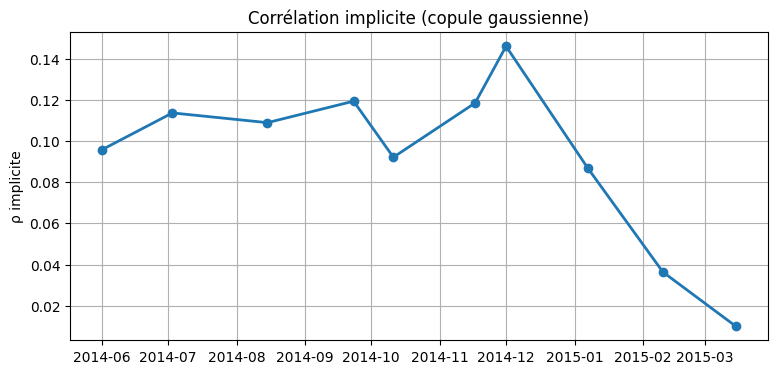

In [13]:
plt.figure(figsize=(9, 4))
plt.plot(dates, rho_t, marker="o", linewidth=2)
plt.ylabel("ρ implicite")
plt.title("Corrélation implicite (copule gaussienne)")
plt.grid(True)
plt.show()


In [14]:
def price_single_tranche(rho, hazard, tranche_index):
    a, d = tranches[tranche_index]

    U = gaussian_copula_uniforms(rho)
    tau = -np.log(U) / hazard

    L_prev = np.zeros(M)
    default_leg = 0.0
    premium_leg = 0.0

    for t in payment_times:
        defaults = (tau <= t).sum(axis=1)
        L = (1 - R) * defaults / N
        Lt = tranche_loss(L, a, d)

        default_leg += discount(t) * np.mean(Lt - L_prev)

        outstanding_prev = d - a - L_prev
        outstanding_now = d - a - Lt
        premium_leg += discount(t) * np.mean(
            0.5 * (outstanding_prev + outstanding_now)
        )

        L_prev = Lt

    if premium_leg < 1e-10:
        return 0.0

    return default_leg / premium_leg


In [15]:
def implied_rho_tranche(market_spread, hazard, tranche_index):

    def objective(x):
        rho = x[0]
        model_spread = price_single_tranche(rho, hazard, tranche_index)
        return (model_spread - market_spread)**2

    res = differential_evolution(
        objective,
        bounds=[(0.01, 0.99)],
        strategy="best1bin",
        maxiter=20,
        popsize=10,
        seed=123,
        polish=True
    )

    return res.x[0]


In [16]:
attachment_points = [a for a, _ in tranches]

smiles = []  # shape: (n_dates, n_tranches)

for i in range(len(df)):
    h = hazard_from_index(df.loc[i, "CDS_Index"])
    implied_rhos = []

    for k in range(len(tranches)):
        rho_k = implied_rho_tranche(
            market_spreads[i, k],
            h,
            tranche_index=k
        )
        implied_rhos.append(rho_k)

    smiles.append(implied_rhos)

smiles = np.array(smiles)


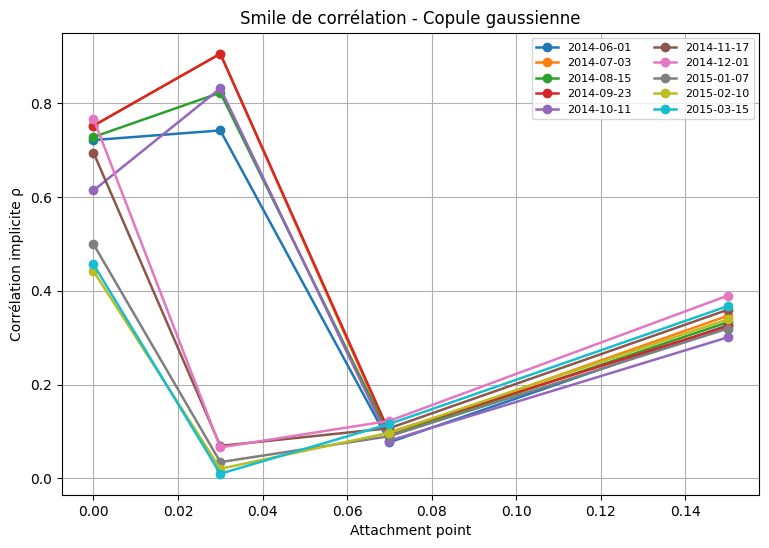

In [17]:
dates = df["Date"]

plt.figure(figsize=(9, 6))

for i in range(len(df)):
    plt.plot(
        attachment_points,
        smiles[i],
        marker="o",
        linewidth=1.8,
        label=dates[i].strftime("%Y-%m-%d")
    )

plt.xlabel("Attachment point")
plt.ylabel("Corrélation implicite ρ")
plt.title("Smile de corrélation - Copule gaussienne")
plt.grid(True)
plt.legend(fontsize=8, ncol=2)
plt.show()


C:\Users\alexb\AppData\Local\Temp\ipykernel_8180\1116349225.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


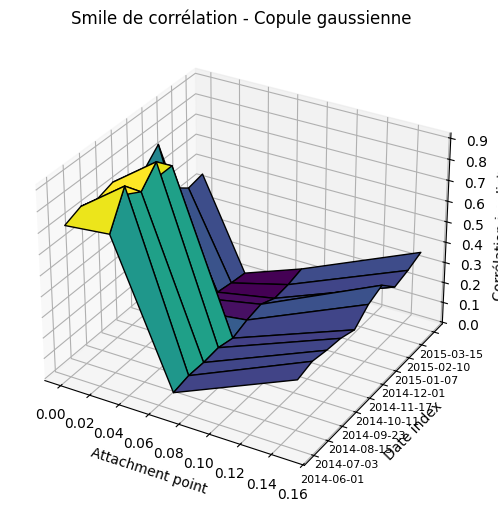

In [23]:
# Surface plot de la smile de corrélation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

# Convert dates to numeric values (days since first date)
dates_numeric = np.arange(len(dates))

X, Y = np.meshgrid(attachment_points, dates_numeric)
Z = smiles
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="k")
ax.set_xlabel("Attachment point")
ax.set_ylabel("Date index")
ax.set_zlabel("Corrélation implicite ρ")
ax.set_title("Smile de corrélation - Copule gaussienne")

# Update y-axis labels to show actual dates
date_labels = [d.strftime("%Y-%m-%d") for d in dates]
ax.set_yticks(dates_numeric)
ax.set_yticklabels(date_labels, fontsize=8)

plt.tight_layout()
plt.show()

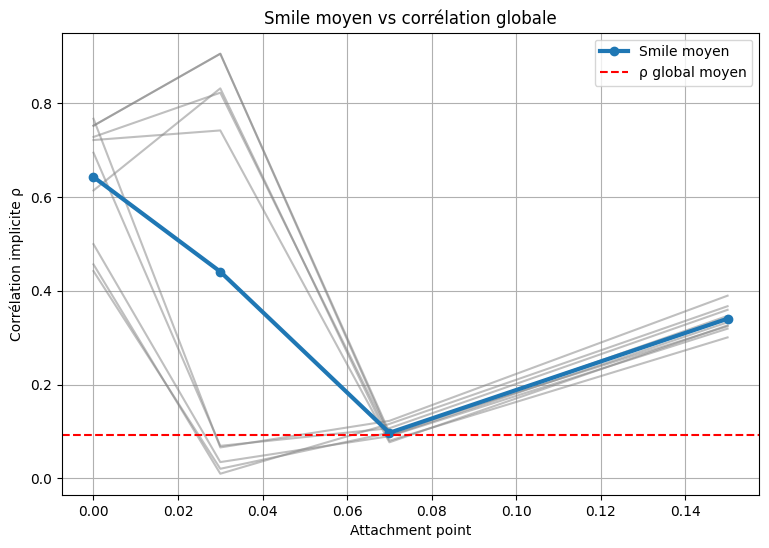

In [18]:
plt.figure(figsize=(9, 6))

for i in range(len(df)):
    plt.plot(
        attachment_points,
        smiles[i],
        color="gray",
        alpha=0.5
    )

plt.plot(
    attachment_points,
    np.mean(smiles, axis=0),
    marker="o",
    linewidth=3,
    label="Smile moyen"
)

plt.axhline(
    np.mean(rho_t),
    color="red",
    linestyle="--",
    label="ρ global moyen"
)

plt.xlabel("Attachment point")
plt.ylabel("Corrélation implicite ρ")
plt.title("Smile moyen vs corrélation globale")
plt.grid(True)
plt.legend()
plt.show()
